#Imports and Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#imports
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
import time
import re
import json
import string
from numpy import linalg as la

In [ ]:
#We create the path to our tweets file and store in the line variable the information of each tweet from the json file and we also create the path to the ids csv

tweets_path = "/content/drive/MyDrive/IRWA/FinalProject/IRWA_data_2023/Rus_Ukr_war_data.json"
with open(tweets_path) as fp:
    lines = fp.readlines()

id_to_docs_path = "/content/drive/MyDrive/IRWA/FinalProject/IRWA_data_2023/Rus_Ukr_war_data_ids.csv"

#Functions from lab 1


In [ ]:
#first of all we will convert our data into a dataframe, we will only take the variables we are interested in (columns of the df)

import pandas as pd
df = pd.DataFrame(columns = ['Id','Tweet','Date','Hashtags','Likes','Retweets','Url'])

#for each line we will read the variable we want and store it on the df
for l in lines:
  parsed_line = json.loads(l)
  id = parsed_line["id"]
  text = parsed_line["full_text"]
  date = parsed_line["created_at"]
  hashtags = parsed_line["entities"]["hashtags"][0]["text"]
  likes = parsed_line["favorite_count"]
  retweets = parsed_line["retweet_count"]
  try:
    url = parsed_line['entities']['media'][0]['url']
  except (KeyError, IndexError):
    url = None

  row = {'Id':id,'Tweet':text,'Date':date,'Hashtags':hashtags,'Likes':likes,'Retweets':retweets,'Url':url}
  new_row = pd.DataFrame([row])
  df = pd.concat([df, new_row], ignore_index=True)

#we also store the data from the csv file into a df
df_docs = pd.read_csv(id_to_docs_path, delimiter='\t', names=['Doc','Id'])

In [ ]:
result_df = pd.merge(df, df_docs, on='Id', how='inner')
result_df = result_df[['Doc','Id','Tweet','Date','Hashtags','Likes','Retweets','Url']]
display(result_df)

,Doc,Id,Tweet,Date,Hashtags,Likes,Retweets,Url
0,doc_1,1575918221013979136,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,Fri Sep 30 18:39:17 +0000 2022,RussiainvadesUkraine,0,0,None
1,doc_2,1575918081461080065,🇺🇦❤️ The Armed Forces liberated the village of...,Fri Sep 30 18:38:44 +0000 2022,Drobysheve,0,0,https://t.co/ifg0RXDMBQ
2,doc_3,1575917992390823936,ALERT 🚨Poland preps anti-radiation tablets ove...,Fri Sep 30 18:38:23 +0000 2022,NATO,0,0,None
3,doc_4,1575917907774967809,I’m still waiting for my google map 🗺️ to upda...,Fri Sep 30 18:38:03 +0000 2022,Putin,0,0,None
4,doc_5,1575917878410301441,@EmmanuelMacron probably you're right or you h...,Fri Sep 30 18:37:56 +0000 2022,European,0,0,None
...,...,...,...,...,...,...,...,...
3995,doc_3996,1575154617620504576,🎥 Ukraine’s president has warned that Russia’s...,Wed Sep 28 16:05:00 +0000 2022,UkraineRussiaWar,4,1,https://t.co/Ld9SN2pz25
3996,doc_3997,1575154444165156864,Germany amusingly shares days old intelligense...,Wed Sep 28 16:04:19 +0000 2022,germany,0,0,None
3997,doc_3998,1575154440012812288,The US Embassy in Moscow is urging Americans t...,Wed Sep 28 16:04:18 +0000 2022,fakenewsfilter,0,0,https://t.co/uI4jNf1n18
3998,doc_3999,1575154351273873410,After the staged fake referendum as of Septemb...,Wed Sep 28 16:03:56 +0000 2022,UkraineRussiaWar,13,2,https://t.co/XQOJq8b3M1


In [ ]:
#now we will use the structure of build terms seen on the first lab to pre-process the text of each tweet
#we will add a few lines to eliminate from the tweets the urls, the @s, the numbers, the #s and the emojis
def build_terms(line):
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words("english"))
  punctuations = string.punctuation

  line =  line.lower() ## Transform in lowercase
  line = re.sub(r'http.*', '',line)
  line = re.sub(r'@\w+', '', line)
  line = re.sub(r'\d+','', line)
  line = re.sub(r'#\w+|[^\x00-\x7F]+|['+ re.escape(punctuations) + ']', ' ',line)
  line=  line.split() ## Tokenize the text to get a list of terms
  line=[x for x in line if x not in stop_words]  ##eliminate the stopwords
  line=[stemmer.stem(word) for word in line] ## perform stemming

  return line

#Indexing

##1.Build inverted Index

In [ ]:
#we create this function to create the inverted index
def create_index(lines):
    index = defaultdict(list)
    dictionary = {}
    term_id = 0

    for line in lines:
        result = result_df[result_df['Tweet'] == line]
        doc_number = result.iloc[0]['Doc']

        terms = build_terms(line)

        current_page_index = {}
        for position, term in enumerate(terms):
            if term not in dictionary:
              term_id +=1
              string_id = "term_id_"+str(term_id)
              dictionary[term] = string_id
            else:
              string_id = dictionary[term]
            try:
                current_page_index[string_id][1].append(position)
            except:
                current_page_index[string_id]=[doc_number, [position]]

        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

    return index, dictionary

In [ ]:
start_time = time.time()
index, dictionary = create_index(result_df['Tweet'])
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 6.76 seconds


##2. Propose test queries



In [ ]:
def search(query, index, dictionary):
    """
    The output is the list of documents that contain all of the query terms.
    So, we will get the list of documents for each query term, and take the intersection of them.
    """
    query = build_terms(query)
    first_term = query[0]
    try:
        id = dictionary[first_term]
        docs = set(posting[0] for posting in index[id])
    except:
        docs = set()

    for term in query[1:]:
        try:
            id = dictionary[first_term]
            term_docs = set(posting[0] for posting in index[id])
            docs = docs.intersection(term_docs)
        except:
            docs = set()

    docs = list(docs)
    return docs

In [ ]:
queries = ['Air bombs', 'UN Congress', "Putin's next step", 'Dead Soldiers', 'World War']
for query in queries:

  docs = search(query, index, dictionary)
  top = 10

  print("\n======================\nSample of {} results out of {} for the searched query: '{}'".format(top, len(docs), query))
  for d_id in docs[:top]:
    print("Doc number: "+d_id)


Sample of 10 results out of 33 for the searched query: 'Air bombs'
Doc number: doc_3611
Doc number: doc_1287
Doc number: doc_2324
Doc number: doc_2604
Doc number: doc_3418
Doc number: doc_3537
Doc number: doc_1951
Doc number: doc_3329
Doc number: doc_3196
Doc number: doc_2746

Sample of 10 results out of 21 for the searched query: 'UN Congress'
Doc number: doc_2086
Doc number: doc_563
Doc number: doc_3647
Doc number: doc_3297
Doc number: doc_1539
Doc number: doc_2248
Doc number: doc_2079
Doc number: doc_299
Doc number: doc_1343
Doc number: doc_420

Sample of 10 results out of 477 for the searched query: 'Putin's next step'
Doc number: doc_349
Doc number: doc_364
Doc number: doc_402
Doc number: doc_1885
Doc number: doc_400
Doc number: doc_1781
Doc number: doc_2530
Doc number: doc_353
Doc number: doc_1593
Doc number: doc_1569

Sample of 10 results out of 42 for the searched query: 'Dead Soldiers'
Doc number: doc_2749
Doc number: doc_990
Doc number: doc_1100
Doc number: doc_908
Doc numbe

##3.Rank results

In [ ]:
#we create this function to create the inverted index and compute the tf, df and idf values
def create_index_tfidf(lines, num_docs):
    index = defaultdict(list)
    dictionary = {}
    term_id = 0
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    idf = defaultdict(float)

    for line in lines:

        result = result_df[result_df['Tweet'] == line]
        doc_number = result.iloc[0]['Doc']

        terms = build_terms(line)

        current_page_index = {}
        for position, term in enumerate(terms):
            if term not in dictionary:
              term_id +=1
              string_id = "term_id_"+str(term_id)
              dictionary[term] = string_id
            else:
              string_id = dictionary[term]
            try:
                current_page_index[string_id][1].append(position)
            except:
                current_page_index[string_id]=[doc_number, [position]]

        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        #normalize term frequencies
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():

            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4))

            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        # Compute IDF
        for term in df:
            idf[term] = np.round(np.log(float(num_docs/df[term])), 4)

    return index, tf, df, idf, dictionary

In [ ]:
start_time = time.time()
num_documents = len(result_df['Tweet'])
index_tf, tf, df, idf, dictionary_tf = create_index_tfidf(result_df['Tweet'], num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 187.71 seconds


In [ ]:
def rank_documents(terms, docs, index, idf, tf, dictionary):

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    processed_docs = set()
    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        try:
          if dictionary[term] not in index:
              continue
        except:
          continue
        term_id = dictionary[term]
        processed_docs = set()

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]= query_terms_count[term] / query_norm*idf[term_id]
        # Generate doc_vectors for matching docs

        for doc_index, (doc, postings) in enumerate(index[term_id]):
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term_id][doc_index] * idf[term_id]

    # Calculate the score of each doc
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_scores = [x[0] for x in doc_scores]

    return result_docs, result_scores

In [ ]:
def search_tf_idf(query1, index, dictionary):
    """
    The output is the list of documents that contain all of the query terms.
    So, we will get the list of documents for each query term, and take the intersection of them.
    """
    query = build_terms(query1)
    first_term = query[0]
    id = dictionary[first_term]
    docs = set(posting[0] for posting in index[id])

    for term in query[1:]:
      id = dictionary[first_term]
      term_docs = set(posting[0] for posting in index[id])
      docs = docs.intersection(term_docs)

    docs = list(docs)
    ranked_docs, ranked_scores = rank_documents(query, docs, index, idf, tf, dictionary)
    return ranked_docs, ranked_scores

In [ ]:
queries = ['Air bombs', 'UN Congress', "Putin's next step", 'Dead Soldiers', 'World War']
for query in queries:

  docs, ranked_scores = search_tf_idf(query, index_tf, dictionary_tf)
  top = 10

  print("\n======================\nSample of {} results out of {} for the searched query: '{}'".format(top, len(docs), query))
  for d_id in docs[:top]:
    print("Doc number: "+d_id)


Sample of 10 results out of 33 for the searched query: 'Air bombs'
Doc number: doc_3418
Doc number: doc_3688
Doc number: doc_1951
Doc number: doc_3300
Doc number: doc_3141
Doc number: doc_196
Doc number: doc_2019
Doc number: doc_1973
Doc number: doc_36
Doc number: doc_2746

Sample of 10 results out of 21 for the searched query: 'UN Congress'
Doc number: doc_2086
Doc number: doc_3769
Doc number: doc_3297
Doc number: doc_3647
Doc number: doc_1618
Doc number: doc_3262
Doc number: doc_2248
Doc number: doc_2152
Doc number: doc_299
Doc number: doc_563

Sample of 10 results out of 477 for the searched query: 'Putin's next step'
Doc number: doc_1825
Doc number: doc_1669
Doc number: doc_1950
Doc number: doc_1959
Doc number: doc_1023
Doc number: doc_1049
Doc number: doc_1071
Doc number: doc_737
Doc number: doc_3047
Doc number: doc_2640

Sample of 10 results out of 42 for the searched query: 'Dead Soldiers'
Doc number: doc_780
Doc number: doc_2547
Doc number: doc_860
Doc number: doc_1051
Doc num

#Evaluation

##Evaluation Components

In [ ]:
#we import the evaluation_get to take the subset of our dataset with which we will evaluate the proposed queries
evaluation_path = "/content/drive/MyDrive/IRWA/FinalProject/IRWA_data_2023/Evaluation_gt.csv"

#we also store the data from the csv file into a df
evaluation_df = pd.read_csv(evaluation_path, delimiter=',', names=['Doc','Query_Id', 'Label'])
evaluation_df.drop(index=evaluation_df.index[0], axis=0, inplace=True)
evaluation_df['Label'] = evaluation_df['Label'].astype(int)

display(evaluation_df.head(10))

,Doc,Query_Id,Label
1,doc_2052,Q3,1
2,doc_164,Q3,1
3,doc_411,Q3,1
4,doc_1805,Q3,1
5,doc_3442,Q3,1
6,doc_2657,Q3,1
7,doc_1534,Q3,1
8,doc_383,Q3,1
9,doc_1618,Q3,1
10,doc_63,Q3,1


In [ ]:
subset_df = pd.merge(result_df, evaluation_df, on='Doc', how='inner')

##Evaluation techniques functions


###Precision@K

In [ ]:
def precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query

  order = np.argsort(y_score)[::-1]
  doc_score = np.take(doc_score, order[:k])
  relevant = sum(doc_score == 1)

  return float(relevant) / k #calculae precision at k, which is the number of relevant documents trieved at k

###Recall@K

In [ ]:
def recall_at_k(doc_score, y_score, k=10):
  order = np.argsort(y_score)[::-1]
  doc_score = np.take(doc_score, order[:k])
  relevant = sum(doc_score == 1)

  total_relevant = sum(doc_score)

  return float(relevant) / total_relevant

###Average Precision@K


In [ ]:
def avg_precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1) #Total number of gt positives
    order = np.argsort(y_score)[::-1] #same as for precision
    doc_score = np.take(doc_score, order[:k]) #same as for precision
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1: #only add the P@k when the doc is relevant
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1) #calculate P@K (#docs relevant at k/k)
    return prec_at_i / gtp #return ap

###F1-Score@K

In [ ]:
def f1_score_at_k(doc_score, y_score, k=10):
  recall = recall_at_k(doc_score, y_score, k)
  precision = precision_at_k(doc_score, y_score, k)
  return 2 * (precision * recall) / (precision + recall)

###Mean Average Precision@K

In [ ]:
def map_at_k(search_res, k):
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["Query_Id"].unique():  # loop over all query ids
        curr_data = search_res[search_res["Query_Id"] == q]  # select data for current query (get a slice of the dataframe keeping only the data related to the current query)
        avp.append(avg_precision_at_k(np.array(curr_data["Label"]),
                   np.array(curr_data["y_score"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

###Mean Reciprocal Rank@K


In [ ]:
def mrr_at_k(doc_score, y_score, k):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[
                             :k])
    if np.sum(doc_score) == 0:
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)



###Normalized Discounted Cumulative Gain

In [ ]:
def dcg_at_k(doc_score, y_score, k=10): #doc_scire are the labels (ground truth) and y_score are the system scores
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score and take first k.
    gain = 2 ** doc_score - 1  # First we calculate the upper part of the formula which is the CG (use formula 7 above) (notice it is based on the ground truth relevance)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k) #ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

##1. Evaluation of the 3 information needs

In [ ]:
queries_id=['Q1', 'Q2', 'Q3']
queries = ['tank in Kharkiv','Nord Stream pipeline', 'annexation of territories by Russia']
k = 10

for query_id, query in zip(queries_id, queries):
  finaldf = subset_df.drop(subset_df[(subset_df['Query_Id'] != query_id) & (subset_df['Label'] == 0)].index)

  index2, tf, df, idf, dictionary2 = create_index_tfidf(finaldf['Tweet'], len(finaldf['Tweet']))
  ranked_docs, ranked_scores = search_tf_idf(query, index2, dictionary2)

  print("\n======================\nResults for the searched query: {} - '{}'\n".format(query_id, query))

  data = pd.DataFrame({'Doc': ranked_docs, 'y_score': ranked_scores})
  finaldf = pd.merge(data, evaluation_df, on = 'Doc', how = 'inner')

  print("==> Precision @k={}: {}".format(k, precision_at_k(finaldf['Label'], finaldf['y_score']), k))
  print("==> Recall @k={}: {}".format(k, recall_at_k(finaldf['Label'], finaldf['y_score']), k))
  print("==> Average Precision @k={}: {}".format(k, avg_precision_at_k(np.array(finaldf['Label']), np.array(finaldf['y_score'])), k))
  print("==> F1-Score @k={}: {}".format(k, f1_score_at_k(finaldf['Label'], finaldf['y_score']), k=10))
  map_k, avp = map_at_k(finaldf, k)
  print("==> Mean Average Precision (MAP) @k={}: {}".format(k, map_k))
  print("==> Mean Reciprocal Rank (MRR)  @k={}: {}".format(k, mrr_at_k(finaldf['Label'], finaldf['y_score'], k)))
  print("==> Normalized Discounted Cumulative Gain (NDCG) @k={} for query with query_id={}: {}".format(k, query_id, np.round(ndcg_at_k(finaldf['Label'], finaldf['y_score'],k), 4)))



Results for the searched query: Q1 - 'tank in Kharkiv'

==> Precision @k=10: 0.6
==> Recall @k=10: 1.0
==> Average Precision @k=10: 0.6642857142857143
==> F1-Score @k=10: 0.7499999999999999
==> Mean Average Precision (MAP) @k=10: 0.38005952380952385
==> Mean Reciprocal Rank (MRR)  @k=10: 1.0
==> Normalized Discounted Cumulative Gain (NDCG) @k=10 for query with query_id=Q1: 0.8054

Results for the searched query: Q2 - 'Nord Stream pipeline'

==> Precision @k=10: 1.0
==> Recall @k=10: 1.0
==> Average Precision @k=10: 1.0
==> F1-Score @k=10: 1.0
==> Mean Average Precision (MAP) @k=10: 1.0
==> Mean Reciprocal Rank (MRR)  @k=10: 1.0
==> Normalized Discounted Cumulative Gain (NDCG) @k=10 for query with query_id=Q2: 1.0

Results for the searched query: Q3 - 'annexation of territories by Russia'

==> Precision @k=10: 1.0
==> Recall @k=10: 1.0
==> Average Precision @k=10: 1.0
==> F1-Score @k=10: 1.0
==> Mean Average Precision (MAP) @k=10: 1.0
==> Mean Reciprocal Rank (MRR)  @k=10: 1.0
==> Norm

##2. Evaluation of proposed queries

In [ ]:
evaluation_path = "/content/drive/MyDrive/IRWA/FinalProject/IRWA_data_2023/Expert_Judges_gt.csv"

#we also store the data from the csv file into a df
expert_df = pd.read_csv(evaluation_path, delimiter=',', names=['Doc','Query_Id', 'Label'])
expert_df['Label'] = expert_df['Label'].astype(int)

subset_expert_df = pd.merge(result_df, expert_df, on='Doc', how='inner')

In [ ]:
queries_id=['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
queries = ['Air bombs', 'UN Congress', "Putin's next step", 'Dead Soldiers', 'World War']
k = 10

for query_id, query in zip(queries_id, queries):
  finaldf = subset_expert_df.drop(subset_expert_df[(subset_expert_df['Query_Id'] != query_id) & (subset_expert_df['Label'] == 0)].index)

  index3, tf, df, idf, dictionary3 = create_index_tfidf(finaldf['Tweet'], len(finaldf['Tweet']))
  ranked_docs, ranked_scores = search_tf_idf(query, index3, dictionary3)

  print("\n======================\nResults for the searched query: {} - '{}'\n".format(query_id, query))

  data = pd.DataFrame({'Doc': ranked_docs, 'y_score': ranked_scores})
  finaldf = pd.merge(data, expert_df, on = 'Doc', how = 'inner')

  print("==> Precision @k={}: {}".format(k, precision_at_k(finaldf['Label'], finaldf['y_score']), k))
  print("==> Recall @k={}: {}".format(k, recall_at_k(finaldf['Label'], finaldf['y_score']), k))
  print("==> Average Precision @k={}: {}".format(k, avg_precision_at_k(np.array(finaldf['Label']), np.array(finaldf['y_score'])), k))
  print("==> F1-Score @k={}: {}".format(k, f1_score_at_k(finaldf['Label'], finaldf['y_score']), k=10))
  map_k, avp = map_at_k(finaldf, k)
  print("==> Mean Average Precision (MAP) @k={}: {}".format(k, map_k))
  print("==> Mean Reciprocal Rank (MRR)  @k={}: {}".format(k, mrr_at_k(finaldf['Label'], finaldf['y_score'], k)))
  print("==> Normalized Discounted Cumulative Gain (NDCG) @k={} for query with query_id={}: {}".format(k, query_id, np.round(ndcg_at_k(finaldf['Label'], finaldf['y_score'],k), 4)))



Results for the searched query: Q1 - 'Air bombs'

==> Precision @k=10: 0.5
==> Recall @k=10: 1.0
==> Average Precision @k=10: 0.22174603174603175
==> F1-Score @k=10: 0.6666666666666666
==> Mean Average Precision (MAP) @k=10: 0.22174603174603175
==> Mean Reciprocal Rank (MRR)  @k=10: 0.3333333333333333
==> Normalized Discounted Cumulative Gain (NDCG) @k=10 for query with query_id=Q1: 0.4042

Results for the searched query: Q2 - 'UN Congress'

==> Precision @k=10: 0.5
==> Recall @k=10: 1.0
==> Average Precision @k=10: 0.2629761904761905
==> F1-Score @k=10: 0.6666666666666666
==> Mean Average Precision (MAP) @k=10: 0.2629761904761905
==> Mean Reciprocal Rank (MRR)  @k=10: 0.3333333333333333
==> Normalized Discounted Cumulative Gain (NDCG) @k=10 for query with query_id=Q2: 0.4328

Results for the searched query: Q3 - 'Putin's next step'

==> Precision @k=10: 0.4
==> Recall @k=10: 1.0
==> Average Precision @k=10: 0.3076923076923077
==> F1-Score @k=10: 0.5714285714285715
==> Mean Average Pr

##Vector Representation

In [ ]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
#we take each tweet terms and apply Word2Vec
df_terms = pd.DataFrame(columns=['Tweet', 'Terms', 'Number_Terms'])

for element in result_df['Tweet']:
  term_list = build_terms(element)

  row = {'Tweet':element,'Terms':term_list, 'Number_Terms': len(term_list)}
  new_row = pd.DataFrame([row])
  df_terms = pd.concat([df_terms, new_row], ignore_index=True)

In [ ]:
#we transform the terms of each tweet into vectors
vectors = Word2Vec(df_terms['Terms'], workers = 4, min_count = 50)

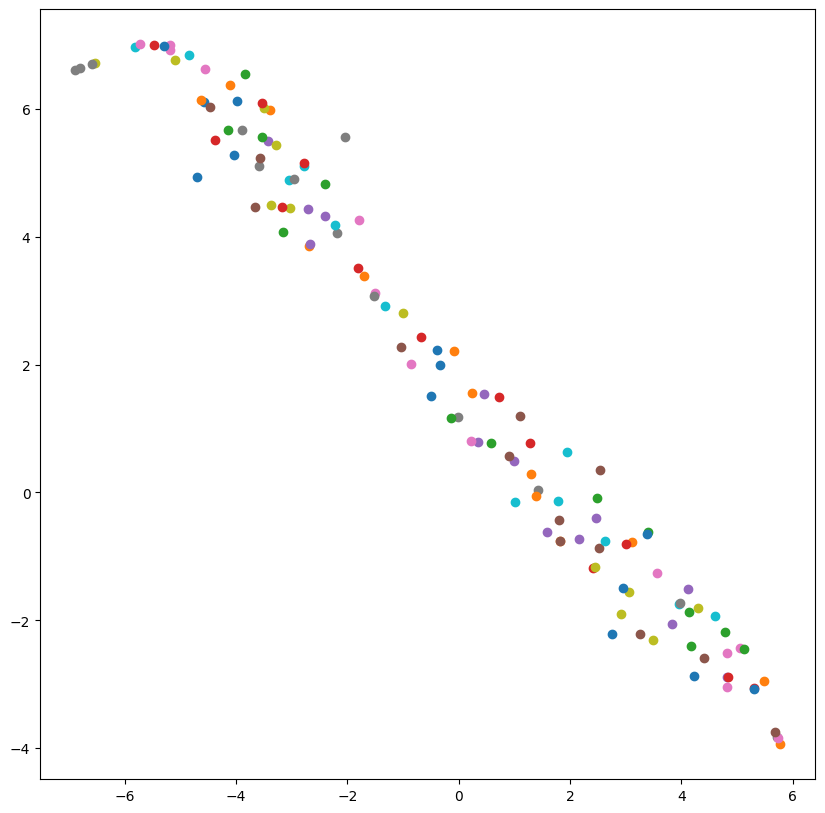

In [ ]:
#now we will do the TSNE plot
labels = []
word_vectors = []
#we will take each word_vector from the vectors model and each index (label)
word_vectors = [vectors.wv[word] for word in vectors.wv.index_to_key]
labels = vectors.wv.index_to_key

#we make the word vectors numpy arrays
word_vectors = np.array(word_vectors)

#now we will create the TSNE model and fit it with the word vectors created before
tsne_model = TSNE(n_components=2, perplexity=40, init='pca', n_iter=1000, random_state=20)
tsne_values = tsne_model.fit_transform(word_vectors)

#we will do a scatter plot with the resulting values from the tsne_model after fitting
x = tsne_values[:, 0]
y = tsne_values[:, 1]

plt.figure(figsize=(10, 10))
for i in range(len(x)):
  plt.scatter(x[i], y[i])

plt.show()